No need to train the model in this section cause the model is already trained

Another way to use the model for prediction

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from ultralytics import YOLO
import cv2
import torch
from datetime import datetime

print(YOLO._version)
print(cv2.__version__)
print(torch.__version__)

1
4.12.0
2.9.1+cpu


In [4]:
class SmartInventorySystem:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.inventory_history = []

    def count_products(self, img_path, show=True):
        results = self.model(img_path)
        for r in results:
            image = cv2.imread(img_path)
            class_indices = r.boxes.cls.int().tolist()
            class_names = r.names
            product_counts = {name: 0 for name in class_names.values()}
            for idx in class_indices:
                product_counts[class_names[idx]] += 1
            # Draw bounding boxes and labels
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                    class_id = box.cls[0].int().item()
                    class_name = r.names[class_id]
                    confidence = box.conf[0].item()
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"{class_name} {confidence:.2f}"
                    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            # Draw product counts on image
            y_offset = 30
            for name, count in product_counts.items():
                cv2.putText(image, f"{name}: {count}", (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                y_offset += 30
            if show:
                import matplotlib.pyplot as plt
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()


        inventory_record = {
            'timestamp': datetime.now(),
            'total_items': sum(product_counts.values()),
            'image_path': img_path
        }
        return product_counts, inventory_record

    def log_inventory(self, counts, inventory_history):
        for name, count in counts.items():
            print(f"Number of {name} detected: {count}")
        print(f"Inventory Record:\n {inventory_history}")



image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\pepsi.jpg: 544x640 5 tin cans, 113.6ms
Speed: 7.6ms preprocess, 113.6ms inference, 14.4ms postprocess per image at shape (1, 3, 544, 640)


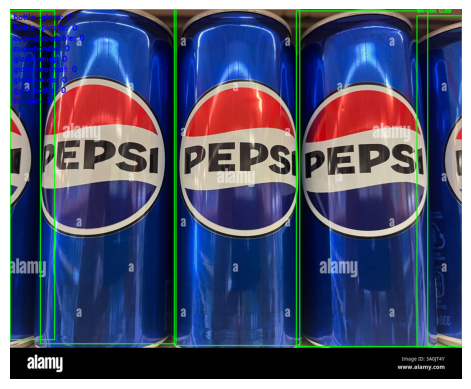


image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\3.png: 640x640 3 bottle-plastics, 109.4ms
Speed: 3.8ms preprocess, 109.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


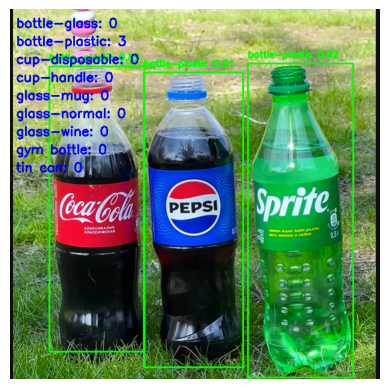

Number of bottle-glass detected: 0
Number of bottle-plastic detected: 3
Number of cup-disposable detected: 0
Number of cup-handle detected: 0
Number of glass-mug detected: 0
Number of glass-normal detected: 0
Number of glass-wine detected: 0
Number of gym bottle detected: 0
Number of tin can detected: 0
Inventory Record:
 {'timestamp': datetime.datetime(2025, 12, 8, 0, 22, 51, 660074), 'total_items': 3, 'image_path': '../media/3.png'}


In [6]:

model_path='../models/runs/detect/fine-tuned-yolo/train/weights/best.pt'
img_path='../media/pepsi.jpg'
img_path2='../media/3.png'

result=SmartInventorySystem(model_path)
result.count_products(img_path)
counts, record=result.count_products(img_path2)
result.log_inventory(counts, record)

Object Detection by Web Cam or Video

In [ ]:
def real_time_inventory(model_path, video_path=''):
    model = YOLO(model_path)  # trained model

    if video_path:
        cap = cv2.VideoCapture(video_path)  # Video
    else:
        cap = cv2.VideoCapture(0)  # Webcam

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Run detection
        results = model(frame)  # Run YOLO inference on the frame
        
        # Manual drawing
        annotated_frame = frame.copy()
        
        print(f"Results: {results[0].boxes}")
        counts = {}
        for r in results:
            class_names = r.names
            counts = {name: 0 for name in class_names.values()}
            
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    confidence = box.conf[0].item()
                    # Only detects with confidence > 0.30
                    if confidence > 0.30:
                        # Get box coordinates
                        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                        class_id = box.cls[0].int().item()
                        class_name = r.names[class_id]
                        
                        # Draw rectangle
                        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
                        # Draw label with confidence
                        label = f"{class_name} {confidence:.2f}"
                        cv2.putText(annotated_frame, label, (x1, y1-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        
                        # Count the detection
                        counts[class_name] += 1

        # Display counts on screen
        y_offset = 30
        for product, count in counts.items():
            cv2.putText(annotated_frame, f"{product}: {count}", 
                       (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            y_offset += 30
        total_count = 0
        for count in counts.values():
            total_count += count
        cv2.putText(annotated_frame, f"Total products: {total_count}", 
                    (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        y_offset += 30
        
        cv2.imshow('YOLO Real-time Detection', annotated_frame)  # Display the annotated frame
        # Break the loop if 'q' is pressed or window is closed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if cv2.getWindowProperty('YOLO Real-time Detection', cv2.WND_PROP_VISIBLE) < 1:
            break
    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()


video_path = 'media/video1.mp4'
real_time_inventory(model_path)



0: 480x640 (no detections), 408.3ms
Speed: 1.6ms preprocess, 408.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)
Results: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (480, 640)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

0: 480x640 (no detections), 651.1ms
Speed: 10.4ms preprocess, 651.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
Results: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (480, 640)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

0: 480x640 (no detections), 364.2ms
Speed: 4.6ms preprocess, 364.2ms inferen

## 1. Model Performance Comparison Between Pre-trained and Fine-Tuned Model



📊 Analyzing /media/img.jpg...

image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\img.jpg: 384x640 1 bottle, 53.7ms
Speed: 1.7ms preprocess, 53.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


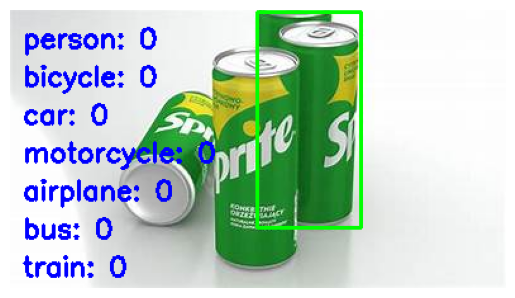

Original model detected: ({'person': 0, 'bicycle': 0, 'car': 0, 'motorcycle': 0, 'airplane': 0, 'bus': 0, 'train': 0, 'truck': 0, 'boat': 0, 'traffic light': 0, 'fire hydrant': 0, 'stop sign': 0, 'parking meter': 0, 'bench': 0, 'bird': 0, 'cat': 0, 'dog': 0, 'horse': 0, 'sheep': 0, 'cow': 0, 'elephant': 0, 'bear': 0, 'zebra': 0, 'giraffe': 0, 'backpack': 0, 'umbrella': 0, 'handbag': 0, 'tie': 0, 'suitcase': 0, 'frisbee': 0, 'skis': 0, 'snowboard': 0, 'sports ball': 0, 'kite': 0, 'baseball bat': 0, 'baseball glove': 0, 'skateboard': 0, 'surfboard': 0, 'tennis racket': 0, 'bottle': 1, 'wine glass': 0, 'cup': 0, 'fork': 0, 'knife': 0, 'spoon': 0, 'bowl': 0, 'banana': 0, 'apple': 0, 'sandwich': 0, 'orange': 0, 'broccoli': 0, 'carrot': 0, 'hot dog': 0, 'pizza': 0, 'donut': 0, 'cake': 0, 'chair': 0, 'couch': 0, 'potted plant': 0, 'bed': 0, 'dining table': 0, 'toilet': 0, 'tv': 0, 'laptop': 0, 'mouse': 0, 'remote': 0, 'keyboard': 0, 'cell phone': 0, 'microwave': 0, 'oven': 0, 'toaster': 0, 's

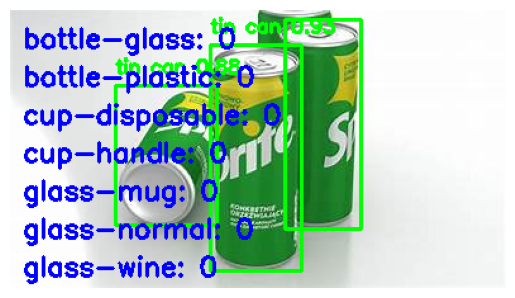

Fine-tuned model detected: ({'bottle-glass': 0, 'bottle-plastic': 0, 'cup-disposable': 0, 'cup-handle': 0, 'glass-mug': 0, 'glass-normal': 0, 'glass-wine': 0, 'gym bottle': 0, 'tin can': 3}, {'timestamp': datetime.datetime(2025, 12, 8, 0, 23, 3, 271264), 'total_items': 3, 'image_path': '../media/img.jpg'})

📊 Analyzing /media/1.png...

image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\1.png: 640x448 1 person, 1 cup, 54.4ms
Speed: 1.7ms preprocess, 54.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


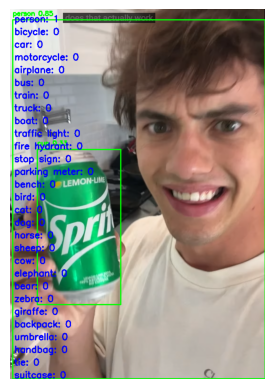

Original model detected: ({'person': 1, 'bicycle': 0, 'car': 0, 'motorcycle': 0, 'airplane': 0, 'bus': 0, 'train': 0, 'truck': 0, 'boat': 0, 'traffic light': 0, 'fire hydrant': 0, 'stop sign': 0, 'parking meter': 0, 'bench': 0, 'bird': 0, 'cat': 0, 'dog': 0, 'horse': 0, 'sheep': 0, 'cow': 0, 'elephant': 0, 'bear': 0, 'zebra': 0, 'giraffe': 0, 'backpack': 0, 'umbrella': 0, 'handbag': 0, 'tie': 0, 'suitcase': 0, 'frisbee': 0, 'skis': 0, 'snowboard': 0, 'sports ball': 0, 'kite': 0, 'baseball bat': 0, 'baseball glove': 0, 'skateboard': 0, 'surfboard': 0, 'tennis racket': 0, 'bottle': 0, 'wine glass': 0, 'cup': 1, 'fork': 0, 'knife': 0, 'spoon': 0, 'bowl': 0, 'banana': 0, 'apple': 0, 'sandwich': 0, 'orange': 0, 'broccoli': 0, 'carrot': 0, 'hot dog': 0, 'pizza': 0, 'donut': 0, 'cake': 0, 'chair': 0, 'couch': 0, 'potted plant': 0, 'bed': 0, 'dining table': 0, 'toilet': 0, 'tv': 0, 'laptop': 0, 'mouse': 0, 'remote': 0, 'keyboard': 0, 'cell phone': 0, 'microwave': 0, 'oven': 0, 'toaster': 0, 's

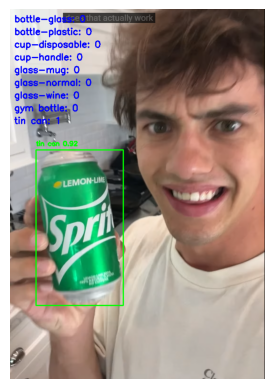

Fine-tuned model detected: ({'bottle-glass': 0, 'bottle-plastic': 0, 'cup-disposable': 0, 'cup-handle': 0, 'glass-mug': 0, 'glass-normal': 0, 'glass-wine': 0, 'gym bottle': 0, 'tin can': 1}, {'timestamp': datetime.datetime(2025, 12, 8, 0, 23, 3, 560889), 'total_items': 1, 'image_path': '../media/1.png'})

📈 COMPARISON SUMMARY

Image: img.jpg
({'bottle-glass': 0, 'bottle-plastic': 0, 'cup-disposable': 0, 'cup-handle': 0, 'glass-mug': 0, 'glass-normal': 0, 'glass-wine': 0, 'gym bottle': 0, 'tin can': 3}, {'timestamp': datetime.datetime(2025, 12, 8, 0, 23, 3, 271264), 'total_items': 3, 'image_path': '../media/img.jpg'})
  Fine-tuned: 3 total products
  Original: 1 total products
  Difference: 2

Image: 1.png
({'bottle-glass': 0, 'bottle-plastic': 0, 'cup-disposable': 0, 'cup-handle': 0, 'glass-mug': 0, 'glass-normal': 0, 'glass-wine': 0, 'gym bottle': 0, 'tin can': 1}, {'timestamp': datetime.datetime(2025, 12, 8, 0, 23, 3, 560889), 'total_items': 1, 'image_path': '../media/1.png'})
  Fine

In [8]:
def simple_model_comparison(original_path, fine_tuned_path, test_images):
    """
    Simple comparison without complex validation
    """
    original_model = SmartInventorySystem(original_path)
    fine_tuned_model = SmartInventorySystem(fine_tuned_path)
    
    comparison_results = []
    
    for img_path in test_images:
        print(f"\n📊 Analyzing {'/media/'+img_path}...")
        
        # Count with original model
        orig_count = original_model.count_products('../media/'+img_path)
        print(f"Original model detected: {orig_count}")
        
        # Count with fine-tuned model
        fine_count = fine_tuned_model.count_products('../media/'+img_path)
        print(f"Fine-tuned model detected: {fine_count}")
        
        comparison_results.append({
            'image': img_path,
            'original': orig_count,
            'fine_tuned': fine_count
        })
    
    return comparison_results

FineTune_model='../models/runs/detect/fine-tuned-yolo/train/weights/best.pt'
original_model='../yolov8n.pt'


test_images = ['img.jpg', '1.png']  # Unseen Images
comparison_results = simple_model_comparison(original_model, FineTune_model, test_images)

# Display comparison summary
print("\n" + "="*50)
print("📈 COMPARISON SUMMARY")
print("="*50)

for result in comparison_results:
    print(f"\nImage: {result['image']}")
    print(result['fine_tuned'])
    fine_total = result['fine_tuned'][1]['total_items']
    orig_total = result['original'][1]['total_items']
    
    print(f"  Fine-tuned: {fine_total} total products")
    print(f"  Original: {orig_total} total products")
    print(f"  Difference: {fine_total - orig_total}")


## 2. Batch Evaluation & Reporting:

In [9]:
import time
import csv

def batch_evaluate_models(original_path, fine_tuned_path, test_images):
    original_model = SmartInventorySystem(original_path)
    fine_tuned_model = SmartInventorySystem(fine_tuned_path)
    
    report_rows = []
    
    for img_path in test_images:
        # Original model
        start_time = time.time()
        orig_counts, _ = original_model.count_products(img_path, False)
        orig_time = time.time() - start_time
        orig_total = sum(orig_counts.values())
        
        # Fine-tuned model
        start_time = time.time()
        fine_counts, _ = fine_tuned_model.count_products(img_path, False)
        fine_time = time.time() - start_time
        fine_total = sum(fine_counts.values())
        
        # Add to report
        report_rows.append({
            'image': img_path.split('/')[-1],
            'original_total': orig_total,
            'fine_tuned_total': fine_total,
            'original_counts': orig_counts,
            'fine_tuned_counts': fine_counts,
            'original_time': orig_time,
            'fine_tuned_time': fine_time
        })
    

    csv_filename='batch_evaluation_report.csv'
    fieldnames=[field for field in report_rows[0].keys()]
    # Writing dictionary to CSV
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()  # Write headers
        writer.writerows(report_rows)  # Write rows

    import pandas as pd 
    # Display as a table 
    df = pd.DataFrame(report_rows)
    display(df)  

# Example usage:
original_model_path = '../yolov8n.pt'
fine_tuned_model_path = '../models/runs/detect/fine-tuned-yolo/train/weights/best.pt'

test_images = ['../media/1.png', '../datasets/test/images/6d22f2d6-65a8-4ddc-a0f6-29a1c5314f2b_jpeg_jpg.rf.57fcc0b043bd7e67cc9fade29d192497.jpg']
batch_evaluate_models(original_model_path, fine_tuned_model_path, test_images)


image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\1.png: 640x448 1 person, 1 cup, 185.5ms
Speed: 5.1ms preprocess, 185.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\media\1.png: 640x448 1 tin can, 124.4ms
Speed: 4.9ms preprocess, 124.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\datasets\test\images\6d22f2d6-65a8-4ddc-a0f6-29a1c5314f2b_jpeg_jpg.rf.57fcc0b043bd7e67cc9fade29d192497.jpg: 640x640 2 persons, 1 vase, 245.4ms
Speed: 7.5ms preprocess, 245.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\User\Desktop\Personal\AI\AI_ML\YOLO-based object detection\notebooks\..\datasets\test\images\6d22f2d6-65a8-4ddc-a0f6-29a1c5314f2b_jpeg_jpg.rf.57fcc0b043bd7e67cc9fade29d192497.jpg: 6

,image,original_total,fine_tuned_total,original_counts,fine_tuned_counts,original_time,fine_tuned_time
0,1.png,2,1,"{'person': 1, 'bicycle': 0, 'car': 0, 'motorcy...","{'bottle-glass': 0, 'bottle-plastic': 0, 'cup-...",0.329610,0.240907
1,6d22f2d6-65a8-4ddc-a0f6-29a1c5314f2b_jpeg_jpg....,3,2,"{'person': 2, 'bicycle': 0, 'car': 0, 'motorcy...","{'bottle-glass': 0, 'bottle-plastic': 0, 'cup-...",0.285233,0.166003
